This notebook explores collaborative filtering problem on movielens 100k dataset. This is based on chapter 8 of the book Deep learning for coders. The main topics covered are:
1. The concept of user and item factors that are derived purely from rating data (user_id, item_id, rating)
2. How dot product of 'latent' user factors and item factors can estimate ratings & how this can be learned by minimsing RMSE loss
3. How user and item biases can be handled (i.e some users tend to rate too low/high, some items more/less popular than others)
4. Neural Network based CF. How concatenated user and item vectors can be fed to an NN for CF. This model also helps to add metadata of users/items if available
5. PCA based visualization of embeddings

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
!head {path}/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [4]:
ratings = pd.read_csv(path/"u.data", sep="\t",header=None,names=['user','movie','rating','timestamp'])

In [5]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
!head {path}/'u.item'

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [7]:
movies = pd.read_csv(path/'u.item',delimiter='|',encoding='latin-1',usecols=(0,1),names=('movie','title'),header=None)

In [8]:
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
ratings = ratings.merge(movies)

In [10]:
ratings.tail()

,user,movie,rating,timestamp,title
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1994)"
99999,655,1641,3,887427810,Dadetown (1995)


In [11]:
dls = CollabDataLoaders.from_df(ratings,item_name='title',bs=64)

In [12]:
dls.show_batch()

,user,title,rating
0,901,Mission: Impossible (1996),4
1,640,Dark City (1998),4
2,497,Batman Returns (1992),3
3,844,Cinderella (1950),3
4,692,Toy Story (1995),4
5,160,Four Rooms (1995),3
6,436,Titanic (1997),5
7,846,Mary Shelley's Frankenstein (1994),3
8,417,Unforgiven (1992),4
9,495,"Shining, The (1980)",5


In [13]:
print(f'total no. of users={len(dls.classes["user"])},total no. of items={len(dls.classes["title"])}')

total no. of users=944,total no. of items=1665


In [14]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

In [15]:
class Demo:
    def __init__(self, a):
        self.a = a
    def say_message(self, message):
        print(f'hello {self.a}, {message}')
        

In [16]:
d = Demo('jobin')

In [17]:
d.say_message('nice to meet you!')

hello jobin, nice to meet you!


In [18]:
x,y = dls.one_batch()

In [19]:
class DotProduct(Module):
    def __init__(self, n_users, n_items, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.item_factors = Embedding(n_items, n_factors)
    
    def forward(self, x):
        user_features = self.user_factors(x[:,0])
        item_features = self.item_factors(x[:,1])
        return (user_features*item_features).sum(axis=1) ## return the activations (i.e predicted ratings)
        

In [20]:
x[:10]

tensor([[ 537,  431],
        [ 789,  856],
        [ 885,  948],
        [ 447,   45],
        [ 170, 1021],
        [ 568, 1486],
        [ 896,  812],
        [ 606, 1508],
        [ 504,  342],
        [ 804, 1174]])

In [21]:
x.shape ## batch size is 64 and columns are user and item ids

torch.Size([64, 2])

In [22]:
model = DotProduct(n_users,n_movies,50)

In [23]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [24]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.361250,1.277730,00:04
1,1.076200,1.116404,00:04
2,0.970184,0.998205,00:04
3,0.835040,0.897002,00:04
4,0.819244,0.880197,00:04


In [25]:
sigmoid_range(torch.Tensor([20]),0,5)

tensor([5.])

In [26]:
class DotProduct(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.item_factors = Embedding(n_items, n_factors)
        self.y_range = y_range
    
    def forward(self, x):
        user_features = self.user_factors(x[:,0])
        item_features = self.item_factors(x[:,1])
        return sigmoid_range((user_features*item_features).sum(axis=1),*self.y_range) 
        

In [27]:
model = DotProduct(n_users,n_movies,50)

In [28]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [29]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.009162,1.003190,00:04
1,0.891935,0.894984,00:04
2,0.691184,0.866669,00:04
3,0.500817,0.868964,00:04
4,0.384487,0.873391,00:04


In [30]:
class DotProductBiased(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.item_factors = Embedding(n_items, n_factors)
        self.y_range = y_range
        self.user_bias = Embedding(n_users,1)
        self.item_bias = Embedding(n_items,1)
    
    def forward(self, x):
        user_features = self.user_factors(x[:,0])
        item_features = self.item_factors(x[:,1])
        user_bias_rows = self.user_bias(x[:,0])
        item_bias_rows = self.item_bias(x[:,1])
        dot_product = (user_features*item_features).sum(axis=1)[:,None]
        predicted_ratings = dot_product + user_bias_rows + item_bias_rows
        return sigmoid_range(predicted_ratings,*self.y_range) 
        

In [31]:
model = DotProductBiased(n_users,n_movies,50)

In [32]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [33]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.919726,0.938824,00:04
1,0.823927,0.856701,00:04
2,0.630036,0.856471,00:04
3,0.396745,0.882627,00:04
4,0.283524,0.889382,00:04


In [34]:
## reducing overfitting using weight decay/regularization ## -> training loss decreases monotonically, but validation loss increases after a point
model = DotProductBiased(n_users,n_movies,50)

In [35]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [36]:
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.933679,0.944717,00:04
1,0.861734,0.872248,00:04
2,0.752115,0.830769,00:04
3,0.580458,0.819318,00:04
4,0.480670,0.819637,00:04


In [37]:
def create_parameters(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

In [38]:
create_parameters((3,2))

Parameter containing:
tensor([[-0.0179, -0.0030],
        [-0.0085,  0.0138],
        [-0.0150,  0.0084]], requires_grad=True)

In [39]:
class DotProductBiasedNoEmbedding(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = create_parameters((n_users, n_factors))
        self.item_factors = create_parameters((n_items, n_factors))
        self.y_range = y_range
        self.user_bias = create_parameters((n_users,1))
        self.item_bias = create_parameters((n_items,1))
    
    def forward(self, x):
        user_features = self.user_factors[x[:,0]]
        item_features = self.item_factors[x[:,1]]
        user_bias_rows = self.user_bias[x[:,0]]
        item_bias_rows = self.item_bias[x[:,1]]
        dot_product = (user_features*item_features).sum(axis=1)[:,None]
        predicted_ratings = dot_product + user_bias_rows + item_bias_rows
        return sigmoid_range(predicted_ratings,*self.y_range) 
        

In [40]:
model = DotProductBiasedNoEmbedding(n_users,n_movies,50)

In [41]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [42]:
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.973967,0.946879,00:04
1,0.859039,0.871104,00:04
2,0.736750,0.830871,00:04
3,0.573366,0.820769,00:04
4,0.468427,0.822484,00:04


In [43]:
movie_bias = learn.model.item_bias.squeeze()

In [44]:
movie_bias.shape

torch.Size([1665])

In [45]:
idxs = movie_bias.argsort()[:5]

In [46]:
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Barb Wire (1996)',
 'Robocop 3 (1993)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Island of Dr. Moreau, The (1996)']

In [47]:
idxs = movie_bias.argsort(descending=True)[:5] ## highest bias movies..would be very popular

In [48]:
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'As Good As It Gets (1997)',
 'Star Wars (1977)']

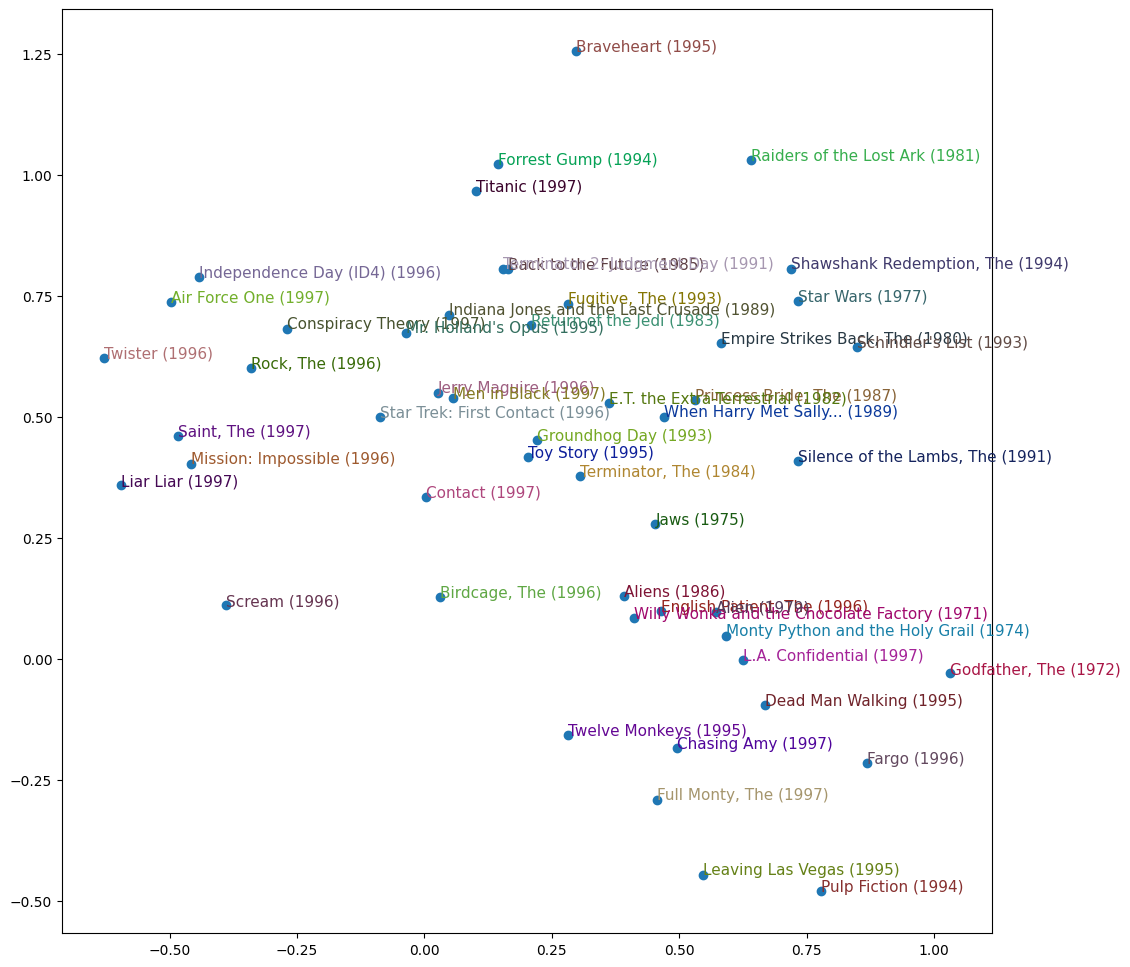

In [53]:
## plotting PCA of movie factors ##

g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.item_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(2)
fac0,fac1 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [20]:
## directly using fastai colab filtering ##
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [21]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936777,0.950668,00:04
1,0.868800,0.871874,00:04
2,0.725207,0.828152,00:04
3,0.587833,0.817794,00:04
4,0.490980,0.819714,00:04


In [107]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [108]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

["Schindler's List (1993)",
 'Titanic (1997)',
 'L.A. Confidential (1997)',
 'Rear Window (1954)',
 'Silence of the Lambs, The (1991)']

In [22]:
## finiding similar movies ##
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idxs = distances.argsort(descending=True)[:10]
[dls.classes['title'][idx] for idx in idxs]


['Silence of the Lambs, The (1991)',
 'You So Crazy (1994)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Right Stuff, The (1983)',
 'Paris Was a Woman (1995)',
 'The Deadly Cure (1996)',
 'Candidate, The (1972)',
 'To Kill a Mockingbird (1962)',
 'Rear Window (1954)',
 'Target (1995)']

In [38]:
embs = get_emb_sz(dls)

In [39]:
embs

[(944, 74), (1665, 102)]

In [69]:
class CollabFilteringNN(Module):
    def __init__(self, user_emb_size, item_emb_size, y_range=(0,5.5), hidden_layer_size=100):
        self.user_factors = Embedding(*user_emb_size)
        self.item_factors = Embedding(*item_emb_size)
        self.layers = nn.Sequential(nn.Linear(user_emb_size[1]+item_emb_size[1],hidden_layer_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_layer_size,1))
        self.y_range = y_range
        
    def forward(self, x): #x is a batch with 2 cols, user_id and item_id
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = torch.cat(embs,axis=1)
        activations = self.layers(x)
        return sigmoid_range(activations,*self.y_range)
        
        

In [70]:
model = CollabFilteringNN(*embs,hidden_layer_size=100)

In [71]:
learn = Learner(dls,model,loss_func=MSELossFlat())

In [73]:
learn.fit_one_cycle(5,5e-3,wd=0.01)

epoch,train_loss,valid_loss,time
0,0.848805,0.899976,00:05
1,0.839167,0.875860,00:05
2,0.795505,0.855110,00:05
3,0.754309,0.854342,00:05
4,0.694557,0.861107,00:05


In [78]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,10])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.991307,0.974857,00:06
1,0.926357,0.918212,00:06
2,0.862570,0.883921,00:05
3,0.831939,0.858571,00:06
4,0.732554,0.860496,00:05


In [82]:
??learn.model

Signature:     
learn.model(
    emb_szs,
    layers,
    *,
    ps: 'float | MutableSequence' = None,
    embed_p: 'float' = 0.0,
    y_range=None,
    use_bn: 'bool' = True,
    bn_final: 'bool' = False,
    bn_cont: 'bool' = True,
    act_cls=ReLU(inplace=True),
    lin_first: 'bool' = True,
)
Call signature: learn.model(*input, **kwargs)
Type:           EmbeddingNN
String form:   
EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=10, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(10,

In [83]:
ratings

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1994)"


In [87]:
ratings[ratings.user==196][['movie','rating']]

,movie,rating
0,242,3
1518,257,2
13157,111,4
13622,25,4
14668,382,4
28289,202,3
34307,153,5
42467,286,5
42983,66,3
44286,845,4


In [92]:
mov,freq=np.unique(ratings.movie.values,return_counts=True)

In [97]:
item_views_dict = dict(zip(mov,freq))

In [100]:
popular_movies = sorted(item_views_dict.items(), key=operator.itemgetter(1),reverse=True)

In [105]:
top_movies = [k[0] for k in popular_movies[:10]]## top 10 movies

In [106]:
user,freq=np.unique(ratings.user.values,return_counts=True)

In [107]:
user_views_dict = dict(zip(user,freq))

In [108]:
active_users = sorted(user_views_dict.items(), key=operator.itemgetter(1),reverse=True)

In [110]:
top_users = [k[0] for k in active_users[:10]]## top 10 movies

In [111]:
top_users

[405, 655, 13, 450, 276, 416, 537, 303, 234, 393]

In [123]:
sdf = ratings[ratings.user.isin(top_users)][ratings.movie.isin(top_movies)][['user','movie','rating']]

/tmp/ipykernel_22927/1949909069.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sdf = ratings[ratings.user.isin(top_users)][ratings.movie.isin(top_movies)][['user','movie','rating']]


In [128]:
sdf.pivot(index='user', columns='movie', values='rating').fillna('_')
## create a cross-tab view of ratings of active users on popular movies

movie,1,50,100,121,181,258,286,288,294,300
user,,,,,,,,,,
13,3.0,5.0,5.0,5.0,5.0,4.0,3.0,1.0,2.0,1.0
234,3.0,4.0,4.0,_,3.0,2.0,3.0,3.0,3.0,3.0
276,5.0,5.0,5.0,4.0,5.0,5.0,_,4.0,4.0,4.0
303,5.0,5.0,5.0,3.0,5.0,4.0,5.0,4.0,4.0,1.0
393,3.0,5.0,1.0,4.0,4.0,4.0,_,3.0,4.0,_
405,_,5.0,_,_,5.0,_,_,5.0,_,_
416,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
450,4.0,5.0,4.0,3.0,4.0,4.0,4.0,3.0,4.0,4.0
537,2.0,4.0,4.0,1.0,2.0,4.0,3.0,2.0,1.0,1.0
